<a href="https://colab.research.google.com/github/yerinsally/BDA/blob/main/%EC%A0%95%EC%98%88%EB%A6%B0_0219_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**필수 과제**
1. prophet에 대한 파라미터를 모두 다 정리
2. 실제 파라미터를 넣어서 예측값을 고도화
3. 예측값 & 실제값과 비교해서 오차율 계산 (오차율계산법 확인)
4. 기본 prophet 예측값과, 실제 파라미터를 튜닝했을때의 예측값을 비교하고 어떤 파라미터가 실제값에 영향을 주었는지 정리

In [1]:
# import necessary libraries
import numpy as np 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# to predictive A
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA 5기/data/sales_data.csv', encoding='unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [3]:
pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]

In [4]:
# 예측 데이터 새로 만들기
df_1 = df.copy()
df_1 = df_1[df_1.Quantity > 0] # 수량이 마이너스인 값 제거
df_1 = df_1[df_1.UnitPrice > 0] # 가격이 마이너스인 값 제거
df_1['Q_price'] = df_1['Quantity'] * df_1['UnitPrice']
df_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Q_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [5]:
# 두 가지 변수만 가지고 시계열을 예측
df_1 = df_1[['InvoiceDate','Q_price']]
df_1

,InvoiceDate,Q_price
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


In [6]:
# Prpphet은 컬럼의 이름 바꿔줘야 함
# ds : 시계열값, y : 예측값
df_1.rename(columns={'InvoiceDate':'ds','Q_price':'y'},inplace=True)
df_1

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


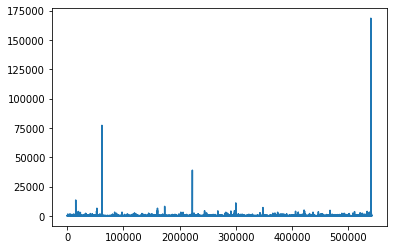

In [7]:
# 간단한 EDA
df_1.y.plot()

In [8]:
# 일별 데이터 합치기 = df_2 최종 데이터
df_1 = df_1.set_index('ds') # 먼저 날짜를 인덱스로 설정
df_2 = df_1.resample('D').sum()
df_2

,y
ds,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-12-05,88741.96
2011-12-06,56713.21
2011-12-07,75439.16


In [9]:
# 인덱스 반드시 풀기
df_2.reset_index(inplace=True) 
df_2

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
369,2011-12-05,88741.96
370,2011-12-06,56713.21
371,2011-12-07,75439.16
372,2011-12-08,82495.00


In [10]:
# train / test 셋으로 나누기
train = df_2[:270]
test = df_2[270:]
print(train, test)

            ds         y
0   2010-12-01  58960.79
1   2010-12-02  47748.38
2   2010-12-03  46943.71
3   2010-12-04      0.00
4   2010-12-05  31774.95
..         ...       ...
265 2011-08-23  25993.68
266 2011-08-24  49035.36
267 2011-08-25  23827.46
268 2011-08-26  25626.44
269 2011-08-27      0.00

[270 rows x 2 columns]             ds          y
270 2011-08-28   10805.03
271 2011-08-29       0.00
272 2011-08-30   31866.31
273 2011-08-31   25380.17
274 2011-09-01   37370.15
..         ...        ...
369 2011-12-05   88741.96
370 2011-12-06   56713.21
371 2011-12-07   75439.16
372 2011-12-08   82495.00
373 2011-12-09  200920.60

[104 rows x 2 columns]


## Prophet

1. 모델의 Trend를 조절하는 파라미터
  - changepoints : 트렌드 변화시점을 명시한 리스트값
  - changepoint_prior_scale	: changepoint(trend) 의 유연성 조절
  - n_changepoints : changepoint 의 개수
  - changepoint_range : changepoint 설정 가능 범위 (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정)


2. Seasonality 관련 파라미터
  - yearly_seasonality(연 계절성), weekly_seasonality(주 계절성), daily_seasonality(일 계절성)
  - seasonality_prior_scale	계절성 반영 강도
  - seasonality_mode : additive / multiplicative

3. Holiday 관련 파라미터
  - holidays : 휴일 또는 이벤트 기간을 명시한 데이터프레임
  - holiday_prior_scale : holiday 반영 강도

In [13]:
# 기본 Prophet 진행
prophet = Prophet()
prophet.fit(df_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/rv9d6ljc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/1cn8c_f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24740', 'data', 'file=/tmp/tmpfjp5fe9p/rv9d6ljc.json', 'init=/tmp/tmpfjp5fe9p/1cn8c_f0.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_modelkio0490x/prophet_model-20230223100844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:08:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


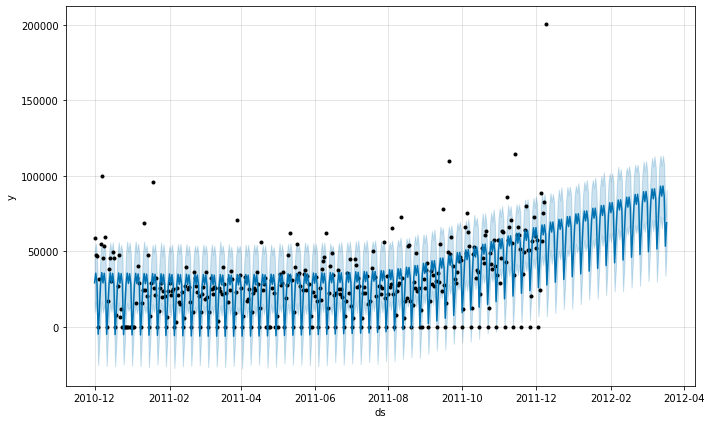

In [14]:
future = prophet.make_future_dataframe(periods=100)
forecast = prophet.predict(future)
fig1 = prophet.plot(forecast)

파란색 선이 모델이 예측한 값, 검정색 점들이 실제 데이터

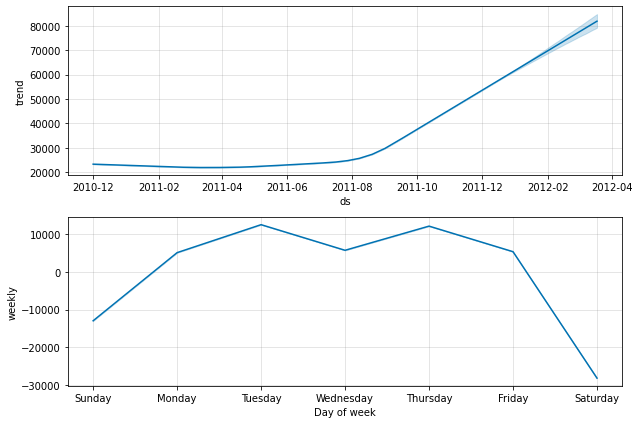

In [15]:
# 피팅된 모델의 컴포넌트들을 시각화
fig2 = prophet.plot_components(forecast)

1. Trend는 점점 증가하는 추세를 보인다. 만약 모델이 데이터의 Trend를 잘 잡아내지 못하는 것 같다면, changepoint_prior_scale 파라미터값을 높여주어 changepoint를 더 민감하게 감지하도록 할 수 있다. 여기서 changepoint란, Trend가 변화하는 지점을 의미한다.
2. 아래 차트는 주 계절성을 의미하는 차트이다. 주로 평일에 실적이 높게 나타나는 경향을 보인다. Seasonality 또한 seasonality_prior_scale 파라미터로 모델 반영 강도를 조절할 수 있다.

### Trend 파라미터

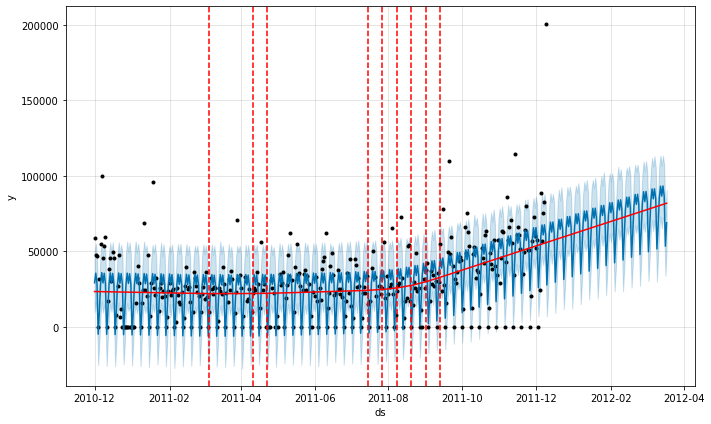

In [16]:
# 모델의 changepoint 를 시각화
from prophet.plot import add_changepoints_to_plot

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

빨간 실선은 트렌드를 의미하며, 빨간 점선은 트렌드가 변화하는 changepoint를 의미

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/cf0l41ao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/bg_9qzvb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28001', 'data', 'file=/tmp/tmpfjp5fe9p/cf0l41ao.json', 'init=/tmp/tmpfjp5fe9p/bg_9qzvb.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_modelu0vdj1fa/prophet_model-20230223100942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:09:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:09:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


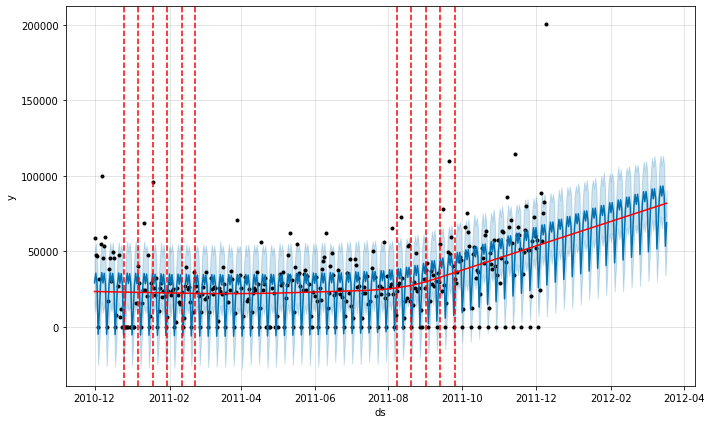

In [17]:
# changepoint_prior_scale 값 변경에 따른 Trend 변화 살피기

# changepoint_prior_scale = 0.05 (default)
# changepoint_prior_scale = 0.15

prophet = Prophet(changepoint_prior_scale=0.15)
prophet.fit(df_2)

fig = prophet.plot(forecast)
a2 = add_changepoints_to_plot(fig.gca(), prophet, forecast)

트렌드를 더 유연하게 감지하는 것을 확인할 수 있다.
- 이 값을 너무 높여버리면 overfitting의 위험이 있으니 주의
- 트렌드가 바뀌는 시점을 알고 있다면, changepoints 파라미터를 추가할 수 있고, changepoints 수 또한 n_changepoints로 지정할 수 있음

### Seasonality 파라미터

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/lh4en6gu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/o_y179tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40134', 'data', 'file=/tmp/tmpfjp5fe9p/lh4en6gu.json', 'init=/tmp/tmpfjp5fe9p/o_y179tc.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_modelmf66dgr_/prophet_model-20230223103113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


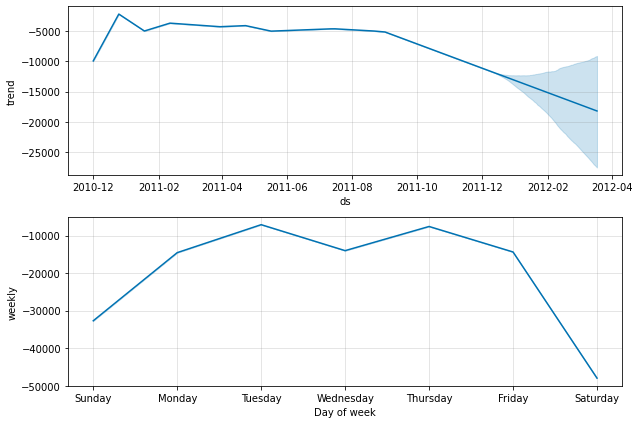

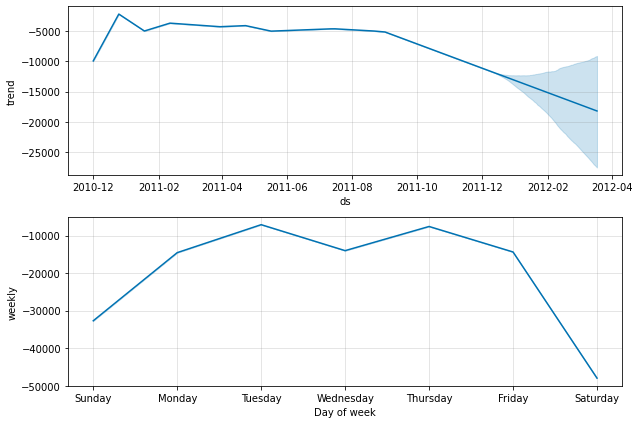

In [29]:
# yearly_seasonality, weekly_seasonality = 10 (default)
# weekly_seasonality = 20

prophet = Prophet(changepoint_prior_scale=0.15,
                   weekly_seasonality=20,
                   daily_seasonality=False)

prophet.fit(df_2)
fig = prophet.plot_components(forecast)
fig

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/avhr78e2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/2zks9qyr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49844', 'data', 'file=/tmp/tmpfjp5fe9p/avhr78e2.json', 'init=/tmp/tmpfjp5fe9p/2zks9qyr.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_modell0onsf35/prophet_model-20230223103139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


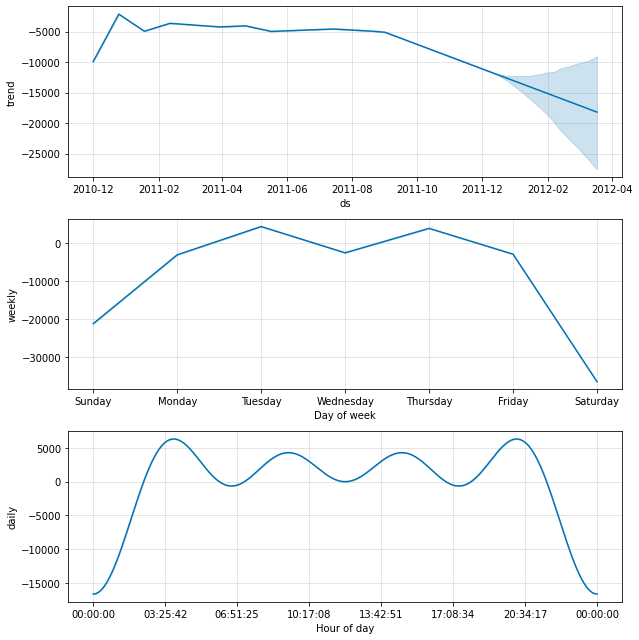

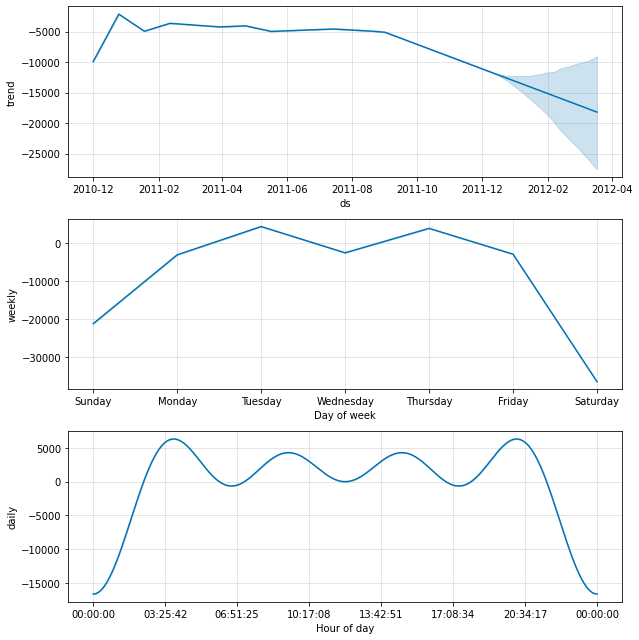

In [30]:
# weekly_seasonality = 20
# daily_sesaonality = True

prophet = Prophet(changepoint_prior_scale=0.15,
                   weekly_seasonality=20,
                   daily_seasonality=True)

prophet.fit(df_2)
fig = prophet.plot_components(forecast)
fig

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/pjt3omrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/pm9d47s5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8247', 'data', 'file=/tmp/tmpfjp5fe9p/pjt3omrj.json', 'init=/tmp/tmpfjp5fe9p/pm9d47s5.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_modelgdtvswjw/prophet_model-20230223101311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


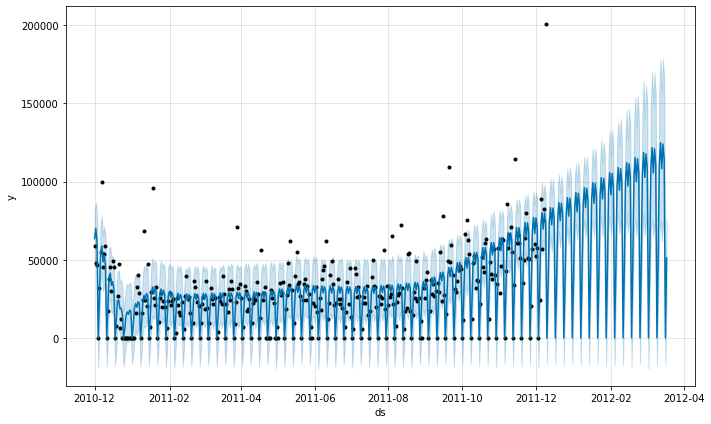

In [22]:
# seasonality_mode
prophet = Prophet(changepoint_prior_scale=0.15,
                  weekly_seasonality=20,
                  daily_seasonality=True,
                  seasonality_mode='multiplicative')

prophet.fit(df_2)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

Seasonality_mode = Additive는 데이터의 진폭이 일정함을 의미, Multiplicative는 데이터의 진폭이 점점 증가하거나 감소하는 것을 의미

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/47phwe5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/2u3v21xx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88205', 'data', 'file=/tmp/tmpfjp5fe9p/47phwe5a.json', 'init=/tmp/tmpfjp5fe9p/2u3v21xx.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_modelqpq2ijnb/prophet_model-20230223101705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


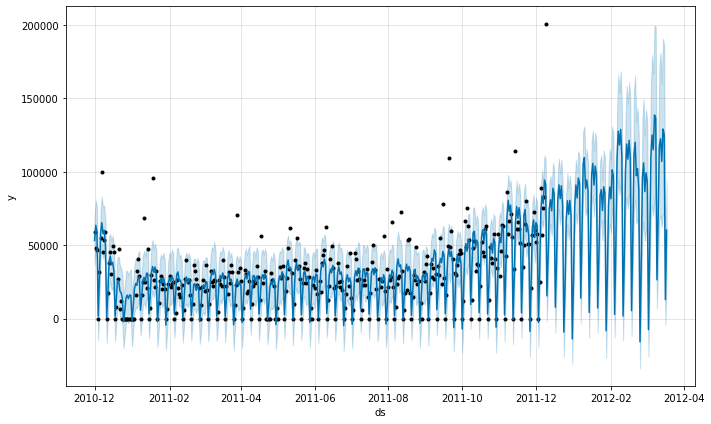

In [24]:
# Specifying Custom Seasonalities
prophet = Prophet(changepoint_prior_scale=0.15,
                  weekly_seasonality=20,
                  daily_seasonality=True,
                  seasonality_mode='multiplicative')

# monthly = 임의로 seasonality를 정의하여 모델에 반영
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

prophet.fit(df_2)
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

주기가 30.5일이고, fourier order가 5인 ‘monthly’ 라는 이름의 seasonality를 추가

### Holiday 파라미터

In [25]:
# 먼저 holiday 정보 (기간,이름) 담은 데이터 프레임을 생성
holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.concat([pd.Series(pd.date_range('2010-12-01', '2012-04-30', freq='D'))])})
holiday

,holiday,ds
0,holiday,2010-12-01
1,holiday,2010-12-02
2,holiday,2010-12-03
3,holiday,2010-12-04
4,holiday,2010-12-05
...,...,...
512,holiday,2012-04-26
513,holiday,2012-04-27
514,holiday,2012-04-28
515,holiday,2012-04-29


In [28]:
prophet = Prophet(changepoint_prior_scale=0.15, 
                  weekly_seasonality=20,
                  daily_seasonality=True,
                  seasonality_mode='multiplicative',
                  holidays=holiday,
                  holidays_prior_scale=15)

prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

prophet.fit(df_2)
forecast = prophet.predict(future)

fig = plot_plotly(prophet, forecast)
fig

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/vi9laghq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/7n__ya8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27180', 'data', 'file=/tmp/tmpfjp5fe9p/vi9laghq.json', 'init=/tmp/tmpfjp5fe9p/7n__ya8g.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_model8qugt2gs/prophet_model-20230223103039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 성능 확인

In [43]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, initial='300 days', period='25 days', horizon='50 days')
df_cv

INFO:prophet:Making 1 forecasts with cutoffs between 2011-10-20 00:00:00 and 2011-10-20 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/n11zjs_t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfjp5fe9p/y41d1ue1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53018', 'data', 'file=/tmp/tmpfjp5fe9p/n11zjs_t.json', 'init=/tmp/tmpfjp5fe9p/y41d1ue1.json', 'output', 'file=/tmp/tmpfjp5fe9p/prophet_model7a6qnp7w/prophet_model-20230223105538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:55:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:55:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-10-21,40398.805108,24504.270469,56537.410663,63226.64,2011-10-20
1,2011-10-22,13195.969070,-4075.750705,29954.833917,0.00,2011-10-20
2,2011-10-23,26567.666422,9294.369650,44465.037556,12339.16,2011-10-20
3,2011-10-24,41204.441607,22774.954725,56770.822860,48752.91,2011-10-20
4,2011-10-25,52602.938287,35764.434595,68736.742306,41314.64,2011-10-20
5,2011-10-26,43818.936297,26743.644185,60795.406994,38059.43,2011-10-20
6,2011-10-27,51286.555482,34624.096850,69139.016873,57291.72,2011-10-20
7,2011-10-28,41486.348312,25339.293886,57227.785597,40565.70,2011-10-20
8,2011-10-29,14283.512273,-2333.472442,31815.374513,0.00,2011-10-20
9,2011-10-30,27655.209626,11186.567970,45164.815987,34571.23,2011-10-20


In [44]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,5 days,2.164198e+08,14711.214048,13817.815413,0.361048,0.716042,0.8
1,6 days,1.188322e+08,10901.017941,10404.149694,0.273228,0.656062,1.0
2,7 days,9.121787e+07,9550.804804,8965.988783,0.154831,0.278185,1.0
3,8 days,5.089731e+07,7134.235212,6304.417161,0.151329,0.136390,1.0
4,9 days,8.030518e+07,8961.315841,7651.425937,0.151329,0.502825,1.0
5,10 days,6.438631e+07,8024.108270,6776.970355,0.151329,0.499205,1.0
6,11 days,1.032161e+08,10159.533109,8640.502133,0.200051,0.531582,1.0
7,12 days,2.164002e+08,14710.547614,12346.535528,0.262810,0.627922,0.8
8,13 days,2.164235e+08,14711.339247,12358.777965,0.262810,0.627759,0.8
9,14 days,2.006513e+08,14165.143937,11739.553774,0.200051,0.266358,0.8


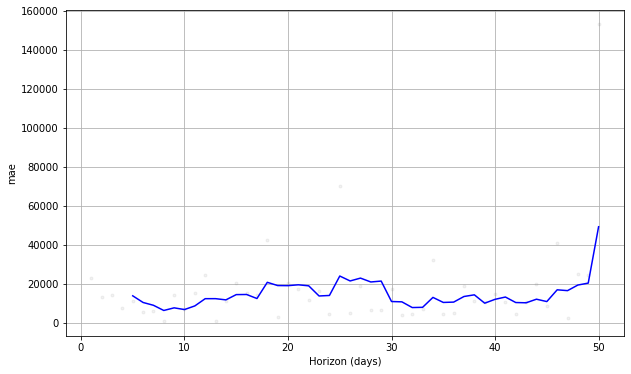

In [46]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric = 'mae')